In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw



In [2]:
from platform import python_version

print(python_version())

3.9.12


In [6]:
pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.3.2
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.2.1
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
bea

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [5]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
# Load
PATH_enc = 'encoder_conv_autoenc.pt'
PATH_dec = 'decoder_conv_autoenc.pt'
encoder.load_state_dict(torch.load(PATH_enc))
encoder.eval()
decoder.load_state_dict(torch.load(PATH_dec))
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.03932034969329834

In [8]:
# Plot losses. Somehow the losses where not saved.
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

NameError: name 'diz_loss' is not defined

<Figure size 1000x800 with 0 Axes>

tensor([-0.0115, -0.1634])
tensor([0.8777, 1.3607])


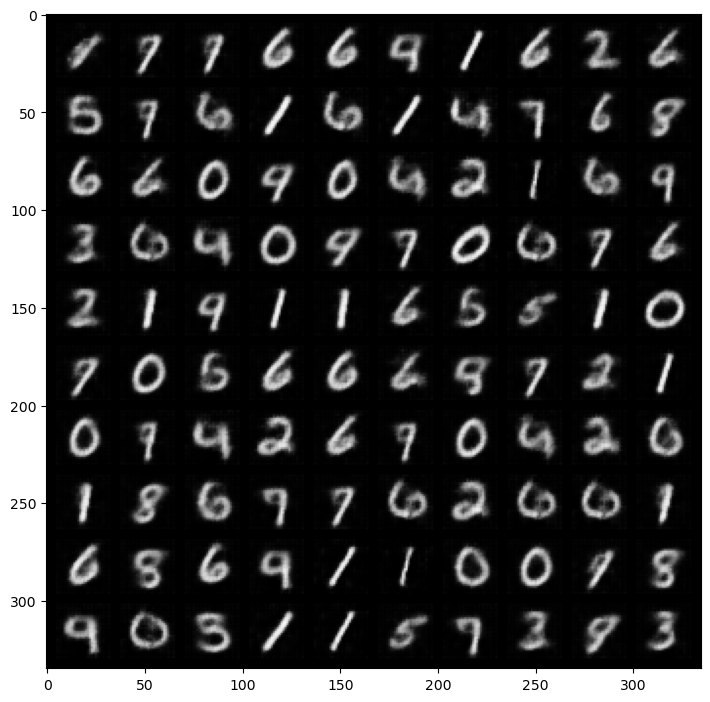

In [9]:
#generate samples from latnt code
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean
    #print(latent)
    #print(latent.shape)

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [17]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [10]:
from tqdm import tqdm

In [11]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:03<00:00, 3224.51it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,0.240591,0.286738,7
1,-0.607497,-0.340900,2
2,0.161667,2.805163,1
3,-0.585463,-1.994725,0
4,0.570041,-0.280448,4
...,...,...,...
9995,-1.036740,-0.070023,2
9996,-0.075183,-0.534253,3
9997,0.057888,0.203255,4
9998,-0.553849,0.327204,5


In [12]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [31]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [32]:
import scipy.stats as ss 

tensor([-0.9500, -0.9500])
tensor([-0.8233, -0.9500])
tensor([-0.6967, -0.9500])
tensor([-0.5700, -0.9500])
tensor([-0.4433, -0.9500])
tensor([-0.3167, -0.9500])
tensor([-0.1900, -0.9500])
tensor([-0.0633, -0.9500])
tensor([ 0.0633, -0.9500])
tensor([ 0.1900, -0.9500])
tensor([ 0.3167, -0.9500])
tensor([ 0.4433, -0.9500])
tensor([ 0.5700, -0.9500])
tensor([ 0.6967, -0.9500])
tensor([ 0.8233, -0.9500])
tensor([ 0.9500, -0.9500])
tensor([-0.9500, -0.8233])
tensor([-0.8233, -0.8233])
tensor([-0.6967, -0.8233])
tensor([-0.5700, -0.8233])
tensor([-0.4433, -0.8233])
tensor([-0.3167, -0.8233])
tensor([-0.1900, -0.8233])
tensor([-0.0633, -0.8233])
tensor([ 0.0633, -0.8233])
tensor([ 0.1900, -0.8233])
tensor([ 0.3167, -0.8233])
tensor([ 0.4433, -0.8233])
tensor([ 0.5700, -0.8233])
tensor([ 0.6967, -0.8233])
tensor([ 0.8233, -0.8233])
tensor([ 0.9500, -0.8233])
tensor([-0.9500, -0.6967])
tensor([-0.8233, -0.6967])
tensor([-0.6967, -0.6967])
tensor([-0.5700, -0.6967])
tensor([-0.4433, -0.6967])
t

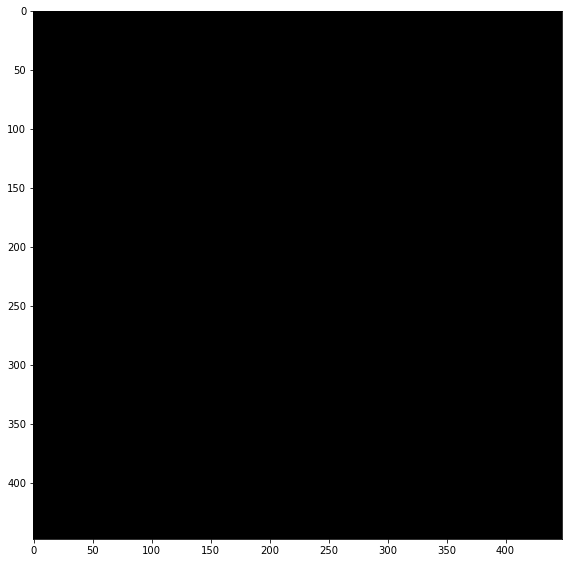

In [69]:
#manifold plot. I found this code online. Yet to understand the norm.ppf
#z_samp = np.random.normal(size=(n_samps, dim_z)) 
#params_x = model.decode(z_samp) 

nx = ny = 16 
x_values = np.linspace(-.95, .95, nx) 
y_values = np.linspace(-.95, .95, ny) 
 
canvas = np.empty((28*ny, 28*nx)) 
for i, yi in enumerate(x_values): 
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[ss.norm.ppf(xi), ss.norm.ppf(yi)]]).astype('float32')
        z_mu = np.array([xi, yi]).astype('float32')
        z_mu = torch.from_numpy(z_mu)
        z_mu = z_mu.to(device)
        print(z_mu)
        #x_mean = model.decode_new(z_mu) 
        x_mean = z_mu
        #x_mean = decoder(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28) 
 
plt.figure(figsize=(8, 10)) 
plt.imshow(canvas, origin="upper", cmap="gray") 
plt.tight_layout() 

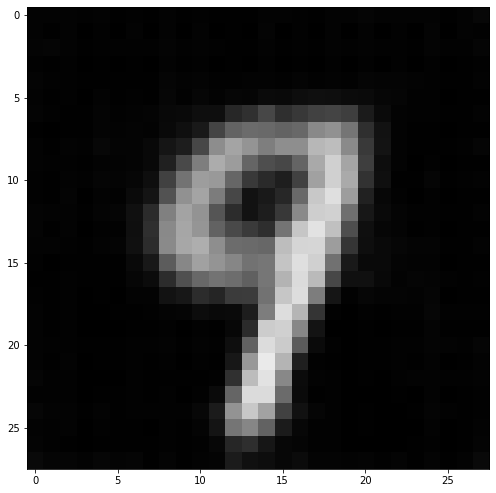

torch.Size([1, 2])


In [24]:
#auxiliary stuff
latent = torch.tensor([[0.5, 0.2]])
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
plt.show()
print(latent.shape)

In [18]:
#Let us take a uniform grid on the latent space. Note that here d=2. The bounds for the grid can be taken from 3 sigma rule
manifold_size = 20
xs = torch.linspace(mean[0]-3*std[0], mean[0]+3*std[0], steps = manifold_size)
ys = torch.linspace(mean[1]-3*std[1], mean[1]+3*std[1], steps = manifold_size)
uniform_grid = torch.cartesian_prod(xs,ys)

In [19]:
uniform_grid.shape

torch.Size([400, 2])

In [33]:
#print(uniform_grid)

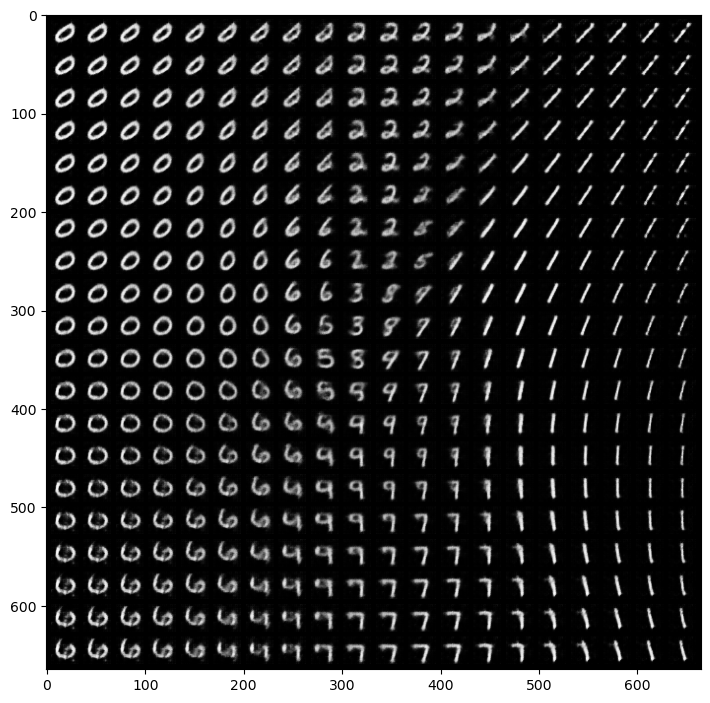

torch.Size([400, 2])


In [29]:
#Manifold plot
latent = uniform_grid
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(img_recon[:manifold_size*manifold_size],manifold_size,5))
plt.show()
print(latent.shape)